# Wood Cutting in Furniture Industry - Capstone Assignment (REL301M) 

## Overview
This repository contains the capstone project for the course Reinforcement Learning (REL301M). Our project focuses on solving the 2D Cutting Stock Problem (CSP) in the furniture industry, optimizing wood cutting to minimize waste and maximize efficiency using heuristic and reinforcement learning approaches.

## Problem Statement
The 2D Cutting Stock Problem involves cutting rectangular demand pieces from larger wooden stock sheets while minimizing waste. This problem has significant applications in industries like furniture manufacturing, where efficient material utilization directly impacts costs and sustainability.

## Reforcement learning (Q-learning)

### 1. Libraries

In [7]:

import numpy as np
import random
import copy
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pickle
import os
import imageio

### 2. Data

In [ ]:
# ============================
# DỮ LIỆU
# ============================
STOCK_WIDTH = 100
STOCK_LENGTH = 100  # stock mới là 100x100

# Một tấm gỗ (stock ban đầu)
stock_sheet = {
    "id": 1,
    "width": STOCK_WIDTH,
    "length": STOCK_LENGTH
}

# Danh sách sản phẩm
# Bàn x 2 (40×75)
# Chân ghế x 16 (4×25)
# Ghế x 4 (20×25)
products_data = [
    {"id": 1, "name": "Table",    "width": 40, "length": 75, "quantity": 2},
    {"id": 2, "name": "TableLeg", "width": 4,  "length": 25, "quantity": 16},
    {"id": 3, "name": "Chair",    "width": 20, "length": 25, "quantity": 4}
]

In [9]:
# ============================
# HÀM KIỂM TRA SÁT CẠNH
# ============================
def is_adjacent(pos1, size1, pos2, size2):
    """
    Kiểm tra xem 2 hình chữ nhật có sát cạnh nhau (chia sẻ 1 biên) hay không.
    pos: (row, col) - vị trí của góc trên bên trái của hình chữ nhật.
    size: (width, height) - kích thước của hình chữ nhật (chiều rộng, chiều cao).
    """
    ## Lấy tọa độ hàng và cột của hình chữ nhật thứ nhất
    r1, c1 = pos1
    # Lấy kích thước (chiều rộng và chiều cao) của hình chữ nhật thứ nhất
    w1, h1 = size1
    # Lấy tọa độ hàng và cột của hình chữ nhật thứ hai
    r2, c2 = pos2
    # Lấy kích thước (chiều rộng và chiều cao) của hình chữ nhật thứ hai
    w2, h2 = size2

    # Tính toán các biên cho hình chữ nhật thứ nhất:
    # top1: biên trên, bottom1: biên dưới, left1: biên trái, right1: biên phải
    top1, bottom1, left1, right1 = r1, r1 + h1, c1, c1 + w1
    # Tính toán các biên cho hình chữ nhật thứ hai:
    top2, bottom2, left2, right2 = r2, r2 + h2, c2, c2 + w2

    # Kiểm tra sát cạnh theo chiều ngang:
    # - Điều kiện giao nhau theo chiều dọc: (bottom1 > top2) và (top1 < bottom2)
    # - Và kiểm tra xem biên phải của hình 1 có trùng với biên trái của hình 2 hay ngược lại
    horizontal_adj = ((bottom1 > top2) and (top1 < bottom2)) and (abs(right1 - left2) == 0 or abs(right2 - left1) == 0)

    # Kiểm tra sát cạnh theo chiều dọc:
    # - Điều kiện giao nhau theo chiều ngang: (right1 > left2) và (left1 < right2)
    # - Và kiểm tra xem biên dưới của hình 1 có trùng với biên trên của hình 2 hay ngược lại
    vertical_adj   = ((right1 > left2) and (left1 < right2)) and (abs(bottom1 - top2) == 0 or abs(bottom2 - top1) == 0)

    # Trả về True nếu một trong hai điều kiện (sát cạnh theo chiều ngang hoặc chiều dọc) được thỏa mãn
    return horizontal_adj or vertical_adj


### 3. Environment 

In [10]:
# ============================
# MÔI TRƯỜNG Q-LEARNING (MULTI-STOCK)
# ============================
class MultiStockCuttingEnv:
    def __init__(self):
        self.reset()   ## Khởi tạo môi trường, gọi reset() để thiết lập trạng thái ban đầu
        
    def reset(self):
        # Khởi tạo lại danh sách stocks với 1 stock ban đầu
        self.stocks = [self.create_new_stock(1)]
        # Reset danh sách sản phẩm theo biến products_data (giả sử products_data đã được định nghĩa từ trước)
        self.products = [dict(p) for p in products_data]
        # Danh sách placements: mỗi mục bao gồm {stock_id, piece_id, pos, size}
        self.placements = []
        return self.get_state()    ## Trả về trạng thái hiện tại của môi trường

    def create_new_stock(self, stock_id):     ## Tạo một stock mới với id, chiều rộng, chiều dài và lưới grid khởi tạo với giá trị -1 (ô trống)
        return {
            "id": stock_id,
            "width": STOCK_WIDTH,  ## Chiều rộng của stock (được định nghĩa bên ngoài)
            "length": STOCK_LENGTH,   ## # Chiều dài của stock (được định nghĩa bên ngoài)
            "grid": np.full((STOCK_LENGTH, STOCK_WIDTH), -1)  ## Tạo ma trận grid kích thước STOCK_LENGTH x STOCK_WIDTH, khởi tạo với -1
        }
    
    def get_active_stock(self):
        return self.stocks[-1]   # # Lấy stock hiện tại đang hoạt động (stock cuối cùng trong danh sách stocks)
    
    def get_state(self):
        """
        State = flatten grid của stock hiện tại + danh sách quantity các sản phẩm
        Lấy trạng thái hiện tại của môi trường:
        State = flatten grid của stock hiện tại + danh sách số lượng (quantity) của từng sản phẩm.
        """
        active = self.get_active_stock()   # Lấy stock hiện tại
        flatten_grid = active["grid"].flatten().tolist()   # Chuyển grid thành danh sách 1 chiều
        q_list = [p["quantity"] for p in self.products]   # Lấy số lượng còn lại của từng sản phẩm
        return tuple(flatten_grid + q_list)    ## Trả về trạng thái dạng tuple gồm flatten_grid và danh sách quantity của sản phẩm
     
    def is_done(self):
        # Xong khi không còn sản phẩm nào cần cắt
        return not any(p["quantity"] > 0 for p in self.products)
    
    # Lấy danh sách các hành động có thể thực hiện (tương ứng với các product có quantity > 0)
    def get_possible_actions(self):
        actions = []
        for p in self.products:
            if p["quantity"] > 0:
                actions.append(p["id"])
        return actions

    def step(self, action):
        """
        Thử đặt sản phẩm (action = product_id) trên stock hiện tại.
        Nếu không tìm thấy vị trí phù hợp trên stock hiện tại, tự động tạo stock mới và đặt vào đó.
        """
        product = None
        for p in self.products:
            if p["id"] == action:
                product = p
                break
        if not product:
            return self.get_state(), -1
        
        w = product["width"]
        h = product["length"]
        
        # Lấy stock hiện tại
        active = self.get_active_stock()
        placed, pos_placed = self.try_place_on_stock(active, action, w, h) #Thử đặt sản phẩm trên stock hiện tại
        
        # Nếu không đặt được trên stock hiện tại, tạo stock mới và đặt lại
        if not placed:
            new_id = self.stocks[-1]["id"] + 1 # Tạo id mới cho stock mới
            new_stock = self.create_new_stock(new_id)
            self.stocks.append(new_stock)
            placed, pos_placed = self.try_place_on_stock(new_stock, action, w, h)
            # Nếu vẫn không đặt được, trả penalty
            if not placed:
                return self.get_state(), -1
        
        # Nếu đặt được, cập nhật số lượng và ghi nhận placement
        product["quantity"] -= 1
        self.placements.append({
            "stock_id": self.get_active_stock()["id"],
            "piece_id": action,
            "pos": pos_placed,
            "size": (w, h)
        })
        reward = self.compute_reward(action, pos_placed, (w, h))
        return self.get_state(), reward

    # Cố gắng đặt sản phẩm có kích thước (w, h) vào stock được chỉ định
    def try_place_on_stock(self, stock, action, w, h):  
        grid = stock["grid"]
        b_w = stock["width"]
        b_h = stock["length"] 
        placed = False   # Biến đánh dấu sản phẩm đã được đặt hay chưa
        pos_placed = None  #Vị trí đặt sản phẩm (nếu đặt được)
        
        # Duyệt theo thứ tự top->down, left->right
        for row in range(b_h - h + 1):
            for col in range(b_w - w + 1):
                ## Kiểm tra xem phần lưới tại vị trí (row, col) có đủ chỗ để đặt sản phẩm (các ô đều bằng -1)
                if np.all(grid[row:row+h, col:col+w] == -1):
                    # Yêu cầu: đặt phải sát ít nhất 1 cạnh của stock
                    if not ((row == 0) or (col == 0) or (row + h == b_h) or (col + w == b_w)):
                        continue
                    ## Đánh dấu các ô trong grid là đã được sử dụng bằng cách gán giá trị action (product_id)
                    grid[row:row+h, col:col+w] = action
                    placed = True
                    pos_placed = (row, col)  ## Ghi nhận vị trí đặt sản phẩm
                    break
            if placed:
                break
        return placed, pos_placed

    def compute_reward(self, piece_id, pos, size):
        """
        Tính reward cho bước đặt sản phẩm theo các quy tắc:
          (a) Đối với bàn (piece_id = 1):
              - Lần đầu tiên: nếu đặt ở góc của stock thì +10, ngược lại +1.
              - Lần thứ hai: nếu sát bàn đầu tiên và sát cạnh stock thì +8, ngược lại +1.
          (b) Đối với các sản phẩm khác: nếu sát cạnh stock hoặc sát với một mảnh đã đặt thì +5, ngược lại +1.
        """
        if piece_id == 1:
            # Lấy danh sách các bàn đã được đặt (piece_id = 1) trong placements
            placed_tables = [p for p in self.placements if p["piece_id"] == 1]
            count_table = len(placed_tables)
            if count_table == 1:
                # Bàn đầu: kiểm tra góc của stock hiện tại
                active = self.get_active_stock()
                # Xác định 4 góc của stock dựa trên kích thước sản phẩm
                corners = [
                    (0, 0),
                    (0, active["width"] - size[0]),
                    (active["length"] - size[1], 0),
                    (active["length"] - size[1], active["width"] - size[0])
                ]
                if pos in corners:
                    return 10 # Đặt ở góc: reward +10
                else:
                    return 1  # Không đặt ở góc: reward +1
            elif count_table == 2:
                # Đây là bàn thứ hai: kiểm tra xem có sát với bàn đầu tiên và sát biên của stock hay không
                first_table = placed_tables[0]
                sat_first = is_adjacent(pos, size, first_table["pos"], first_table["size"])
                row, col = pos
                w_, h_ = size
                active = self.get_active_stock()
                # Kiểm tra nếu sản phẩm chạm biên của stock
                touches_board = (row == 0) or (col == 0) or (row + h_ == active["length"]) or (col + w_ == active["width"])
                if sat_first and touches_board:
                    return 8 #Đủ điều kiện: reward +8
                else:
                    return 1 # Không đủ điều kiện: reward +1
            else:
                return self.reward_for_other(pos, size) # Các trường hợp khác: tính reward cho sản phẩm khác
        else:
            # Đối với các sản phẩm không phải bàn: sử dụng công thức reward cho sản phẩm khác
            return self.reward_for_other(pos, size)
    
    def reward_for_other(self, pos, size):
        # Tính reward cho các sản phẩm không phải bàn
        row, col = pos
        w, h = size
        active = self.get_active_stock()
        # Nếu sản phẩm được đặt sát cạnh biên của stock thì nhận reward +5
        if (row == 0) or (col == 0) or (row + h == active["length"]) or (col + w == active["width"]):
            return 5
        # Kiểm tra xem sản phẩm có sát cạnh với bất kỳ sản phẩm nào đã được đặt trước đó không
        for p in self.placements:
            # Nếu cùng vị trí và kích thước với chính nó thì bỏ qua
            if p["pos"] == pos and p["size"] == size:
                continue
            if is_adjacent(pos, size, p["pos"], p["size"]):
                return 5 # Nếu sát cạnh với sản phẩm nào đó, nhận reward +5
        return 1 ## Các trường hợp khác, nhận reward +1

    def leftover_penalty(self):
        # Tính tổng penalty cho các ô không được sử dụng (giá trị -1) trên tất cả các stock
        total_leftover = sum(np.sum(stock["grid"] == -1) for stock in self.stocks)
        return -0.01 * total_leftover # Mỗi ô dư nhận penalty -0.01

    # Nếu tất cả sản phẩm đã được cắt (quantity bằng 0) thì nhận bonus +50
    def complete_bonus(self):
        if all(p["quantity"] == 0 for p in self.products):
            return 50
        return 0

    def stock_switch_penalty(self):
        # Penalty cho mỗi stock phụ được dùng (ngoài stock đầu tiên)
        extra_stocks = len(self.stocks) - 1
        return -50 * extra_stocks

### 4. Q-Learning Methods

In [11]:
# Khai báo lớp QLearningAgent, đại diện cho tác nhân Q-Learning
class QLearningAgent:
    # Hàm khởi tạo của tác nhân với các tham số:
    # alpha: tốc độ học (learning rate)
    # gamma: hệ số chiết khấu (discount factor)
    # epsilon: xác suất chọn hành động ngẫu nhiên (epsilon cho chính sách epsilon-greedy)
    def __init__(self, alpha=0.1, gamma=0.9, epsilon=0.2):
        self.alpha = alpha          # Gán tốc độ học cho tác nhân
        self.gamma = gamma          # Gán hệ số chiết khấu cho tác nhân
        self.epsilon = epsilon      # Gán epsilon cho chính sách khám phá
        self.q_table = {}           # Khởi tạo bảng Q (dictionary) lưu Q(s, a) cho từng cặp trạng thái và hành động

    # Hàm chuyển đổi trạng thái (state) thành key dạng tuple để lưu trữ trong q_table
    def get_state_key(self, state):
        return tuple(state)         # Chuyển đổi state (thường là list) thành tuple (immutable) để dùng làm key

    # Hàm chọn hành động dựa trên trạng thái hiện tại và danh sách các hành động có thể
    def choose_action(self, state, possible_actions):
        state_key = self.get_state_key(state)  # Lấy key của trạng thái hiện tại
        # Với xác suất epsilon, chọn hành động ngẫu nhiên (khám phá)
        if random.random() < self.epsilon:
            return random.choice(possible_actions)
        # Nếu không, lấy giá trị Q cho từng hành động có thể, mặc định là 0 nếu chưa tồn tại
        q_values = [self.q_table.get((state_key, a), 0) for a in possible_actions]
        max_q = max(q_values)   # Tìm giá trị Q lớn nhất trong danh sách
        # Lấy danh sách các hành động có Q bằng giá trị Q lớn nhất (để xử lý trường hợp có nhiều hành động tối ưu)
        max_actions = [a for a, qv in zip(possible_actions, q_values) if qv == max_q]
        # Trả về một hành động được chọn ngẫu nhiên từ các hành động tối ưu
        return random.choice(max_actions)

    # Hàm cập nhật bảng Q dựa trên trải nghiệm: (state, action, reward, next_state, next_possible_actions)
    def update(self, state, action, reward, next_state, next_possible_actions):
        state_key = self.get_state_key(state)      # Lấy key của trạng thái hiện tại
        next_state_key = self.get_state_key(next_state)  # Lấy key của trạng thái tiếp theo
        # Lấy giá trị Q hiện tại cho cặp (state, action), mặc định là 0 nếu chưa có
        current_q = self.q_table.get((state_key, action), 0)
        if next_possible_actions:
            # Tính giá trị Q tối đa của trạng thái tiếp theo từ các hành động có thể
            next_q = max(self.q_table.get((next_state_key, a), 0) for a in next_possible_actions)
        else:
            next_q = 0  # Nếu không có hành động khả thi ở trạng thái tiếp theo, gán Q = 0
        # Cập nhật giá trị Q mới theo công thức của Q-Learning:
        # Q(s,a) = Q(s,a) + alpha * (reward + gamma * max_a' Q(s',a') - Q(s,a))
        new_q = current_q + self.alpha * (reward + self.gamma * next_q - current_q)
        # Lưu giá trị Q mới vào bảng Q với key là (state_key, action)
        self.q_table[(state_key, action)] = new_q


### 5. Prepare the next state

In [12]:
# ============================
# HUẤN LUYỆN (với agent được truyền vào)
# ============================
def train_q_learning(agent, num_episodes=500, max_steps=50):
    env = MultiStockCuttingEnv()  # Khởi tạo môi trường cắt multi-stock
    rewards_history = []          # Danh sách lưu lại tổng reward của mỗi episode
    best_reward = -float('inf')   # Khởi tạo best_reward với giá trị rất nhỏ
    best_env = None               # Biến lưu môi trường có kết quả tốt nhất

    # Vòng lặp huấn luyện cho số lượng episode đã cho
    for episode in range(num_episodes):
        state = env.reset()       # Reset môi trường về trạng thái ban đầu
        total_reward = 0          # Khởi tạo tổng reward cho episode hiện tại
        # Vòng lặp cho số bước tối đa trong mỗi episode
        for step in range(max_steps):
            possible_actions = env.get_possible_actions()  # Lấy danh sách hành động có thể tại trạng thái hiện tại
            if not possible_actions:                       # Nếu không có hành động nào khả thi, thoát vòng lặp
                break
            action = agent.choose_action(state, possible_actions)  # Chọn hành động theo chiến lược epsilon-greedy của agent
            next_state, r = env.step(action)                # Thực hiện hành động và nhận trạng thái tiếp theo cùng reward
            next_possible_actions = env.get_possible_actions()  # Lấy danh sách hành động khả thi tại trạng thái mới
            agent.update(state, action, r, next_state, next_possible_actions)  # Cập nhật bảng Q dựa trên kinh nghiệm
            total_reward += r       # Cộng reward nhận được vào tổng reward của episode
            state = next_state      # Cập nhật trạng thái hiện tại thành trạng thái tiếp theo
            if env.is_done():       # Nếu môi trường báo hiệu hoàn thành (không còn sản phẩm cần cắt)
                break
        # Cộng thêm các thành phần reward cuối episode:
        total_reward += env.leftover_penalty()   # Phạt cho phần dư (waste) trong stock
        total_reward += env.complete_bonus()       # Thưởng khi hoàn thành việc cắt hết sản phẩm
        total_reward += env.stock_switch_penalty()   # Phạt khi sử dụng stock phụ ngoài stock đầu tiên
        rewards_history.append(total_reward)       # Lưu tổng reward của episode vào danh sách
        if total_reward > best_reward:               # Nếu tổng reward của episode hiện tại tốt hơn best_reward hiện có
            best_reward = total_reward               # Cập nhật best_reward
            best_env = copy.deepcopy(env)            # Lưu một bản sao môi trường hiện tại làm môi trường tốt nhất
        print(f"Episode {episode+1}: Total Reward = {total_reward}")  # In thông tin tổng reward của episode
    return best_env, rewards_history  # Trả về môi trường tốt nhất và lịch sử reward

# ============================
# LƯU VÀ TẢI MODEL (Q-TABLE)
# ============================
def save_q_table(agent, filename="q_table.pkl"):
    with open(filename, "wb") as f:          # Mở file để ghi (binary mode)
        pickle.dump(agent.q_table, f)        # Lưu bảng Q (q_table) của agent vào file
    print(f"Q-table saved to {filename}")     # In thông báo đã lưu thành công

def load_q_table(agent, filename="q_table.pkl"):
    if os.path.exists(filename):             # Kiểm tra file có tồn tại hay không
        with open(filename, "rb") as f:        # Mở file để đọc (binary mode)
            agent.q_table = pickle.load(f)     # Nạp bảng Q (q_table) từ file vào agent
        print(f"Q-table loaded from {filename}")  # In thông báo đã tải thành công
    else:
        print(f"No Q-table file found at {filename}. Training from scratch.")  # Thông báo nếu không tìm thấy file

# ============================
# TÍNH TOÁN DIỆN TÍCH
# ============================
def compute_areas(env):
    # Tính tổng diện tích của tất cả các stock
    total_area = sum(stock["width"] * stock["length"] for stock in env.stocks)
    # Tính diện tích đã được sử dụng bằng cách tính diện tích của từng sản phẩm được đặt
    used_area = sum(p["size"][0] * p["size"][1] for p in env.placements)
    waste_area = total_area - used_area  # Diện tích lãng phí là phần không sử dụng được
    return total_area, used_area, waste_area  # Trả về tổng diện tích, diện tích sử dụng và diện tích lãng phí

# ============================
# IN BẢNG TÓM TẮT
# ============================
def print_best_solution_summary(env):
    print("\nSummary of Q-Learning Cutting:")  # In tiêu đề bảng tóm tắt
    print("+----------+----------+--------------+------------+")
    print("| Stock ID | Piece ID | Dimensions   | Position   |")
    print("+----------+----------+--------------+------------+")
    # Duyệt qua từng placement (vị trí đặt sản phẩm) trong môi trường
    for placement in env.placements:
        stock_id = placement["stock_id"]         # Lấy id của stock chứa sản phẩm
        piece_id = placement["piece_id"]           # Lấy id của sản phẩm (piece)
        w, h = placement["size"]                   # Lấy kích thước (chiều rộng x chiều cao) của sản phẩm
        row, col = placement["pos"]                # Lấy vị trí đặt sản phẩm (hàng, cột)
        dim_str = f"{w}x{h}"                       # Tạo chuỗi mô tả kích thước
        pos_str = f"({row},{col})"                 # Tạo chuỗi mô tả vị trí
        # In một dòng tóm tắt cho placement hiện tại
        print(f"| {stock_id:<8} | {piece_id:<8} | {dim_str:<12} | {pos_str:<10} |")
    print("+----------+----------+--------------+------------+")

# ============================
# VẼ BIỂU ĐỒ REWARD
# ============================
def plot_training_rewards(rewards):
    episodes = range(1, len(rewards)+1)   # Tạo danh sách các episode từ 1 đến số episode đã huấn luyện
    plt.figure(figsize=(8,4))             # Tạo figure với kích thước 8x4 inch
    plt.plot(episodes, rewards, marker='o', color='b')  # Vẽ đường đồ thị reward theo episode
    plt.xlabel("Episode")                 # Gán nhãn trục hoành là "Episode"
    plt.ylabel("Total Reward")            # Gán nhãn trục tung là "Total Reward"
    plt.title("Q-Learning Rewards (Multi-Stock Cutting)")  # Đặt tiêu đề cho đồ thị
    plt.grid(True)                        # Hiển thị lưới trên đồ thị
    plt.show()                            # Hiển thị đồ thị

# ============================
# TRỰC QUAN HÓA KẾT QUẢ
# ============================
def visualize_best_solution(env):
    num_stocks = len(env.stocks)          # Lấy số lượng stock đã được sử dụng
    # Tạo subplot cho từng stock, mỗi stock có một hình vẽ riêng
    fig, axs = plt.subplots(1, num_stocks, figsize=(5*num_stocks, 6))
    if num_stocks == 1:
        axs = [axs]  # Nếu chỉ có 1 stock, chuyển axs thành list để dễ duyệt
    # Duyệt qua từng stock và các trục vẽ tương ứng
    for ax, stock in zip(axs, env.stocks):
        ax.set_title(f"Stock {stock['id']}")  # Đặt tiêu đề cho từng stock theo id
        ax.set_xlim(0, stock["width"])         # Thiết lập giới hạn trục x theo chiều rộng của stock
        ax.set_ylim(0, stock["length"])          # Thiết lập giới hạn trục y theo chiều dài của stock
        ax.grid(True, linewidth=0.5)             # Hiển thị lưới với độ dày đường lưới 0.5
        # Hiển thị hình nền cho stock với màu xám (sử dụng imshow)
        ax.imshow(np.full((stock["length"], stock["width"]), 1), cmap='gray', vmin=0, vmax=1)
        # Danh sách màu sắc để tô màu các sản phẩm khác nhau
        colors = ["#FF5733", "#33FF57", "#3357FF", "#F4C724", "#A833FF", "#33FFF5", "#FF33A8"]
        # Vẽ các placement (sản phẩm được đặt) trên stock hiện tại
        for p in env.placements:
            if p["stock_id"] == stock["id"]:   # Chỉ vẽ các placement thuộc về stock hiện tại
                color = colors[(p["piece_id"] - 1) % len(colors)]  # Chọn màu dựa trên piece_id
                pos = p["pos"]               # Lấy vị trí đặt của sản phẩm
                size = p["size"]             # Lấy kích thước của sản phẩm
                # Tạo hình chữ nhật với vị trí và kích thước đã cho, với đường viền màu đen
                rect = patches.Rectangle((pos[1], pos[0]), size[0], size[1],
                                         linewidth=1.5, edgecolor="black",
                                         facecolor=color, alpha=0.8)
                ax.add_patch(rect)           # Thêm hình chữ nhật vào trục vẽ
    plt.tight_layout()                     # Điều chỉnh layout cho phù hợp
    plt.show()                             # Hiển thị hình ảnh trực quan

# ============================
# TEST EPISODE
# ============================
def simulate_episode(agent, max_steps=50):
    env = MultiStockCuttingEnv()         # Tạo một môi trường mới
    state = env.reset()                  # Reset môi trường và lấy trạng thái ban đầu
    total_reward = 0                     # Khởi tạo tổng reward cho episode
    # Tiến hành vòng lặp cho đến khi môi trường báo hiệu hoàn thành
    while not env.is_done():
        possible_actions = env.get_possible_actions()  # Lấy danh sách hành động có thể
        if not possible_actions:           # Nếu không còn hành động nào khả thi, thoát vòng lặp
            break
        action = agent.choose_action(state, possible_actions)  # Chọn hành động theo chiến lược của agent
        next_state, r = env.step(action)   # Thực hiện hành động và nhận trạng thái tiếp theo cùng reward
        total_reward += r                  # Cộng reward nhận được vào tổng reward
        state = next_state                 # Cập nhật trạng thái hiện tại
    # Cộng thêm các reward/phạt cuối episode
    total_reward += env.leftover_penalty()
    total_reward += env.complete_bonus()
    total_reward += env.stock_switch_penalty()
    return env, total_reward              # Trả về môi trường cuối episode và tổng reward đạt được


### 6. Main

Q-table loaded from q_table.pkl
Loaded Q-table. Running test episode...


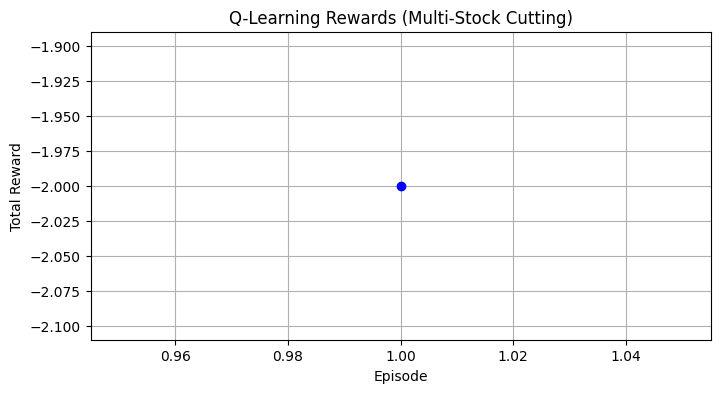


Total Area = 20000
Used Area  = 9600
Waste Area = 10400

Summary of Q-Learning Cutting:
+----------+----------+--------------+------------+
| Stock ID | Piece ID | Dimensions   | Position   |
+----------+----------+--------------+------------+
| 1        | 3        | 20x25        | (0,0)      |
| 1        | 2        | 4x25         | (0,20)     |
| 1        | 2        | 4x25         | (0,24)     |
| 1        | 3        | 20x25        | (0,28)     |
| 1        | 1        | 40x75        | (0,48)     |
| 1        | 3        | 20x25        | (25,0)     |
| 1        | 2        | 4x25         | (0,88)     |
| 2        | 1        | 40x75        | (0,0)      |
| 2        | 2        | 4x25         | (0,40)     |
| 2        | 3        | 20x25        | (0,44)     |
| 2        | 2        | 4x25         | (0,64)     |
| 2        | 2        | 4x25         | (0,68)     |
| 2        | 2        | 4x25         | (0,72)     |
| 2        | 2        | 4x25         | (0,76)     |
| 2        | 2        | 4x2

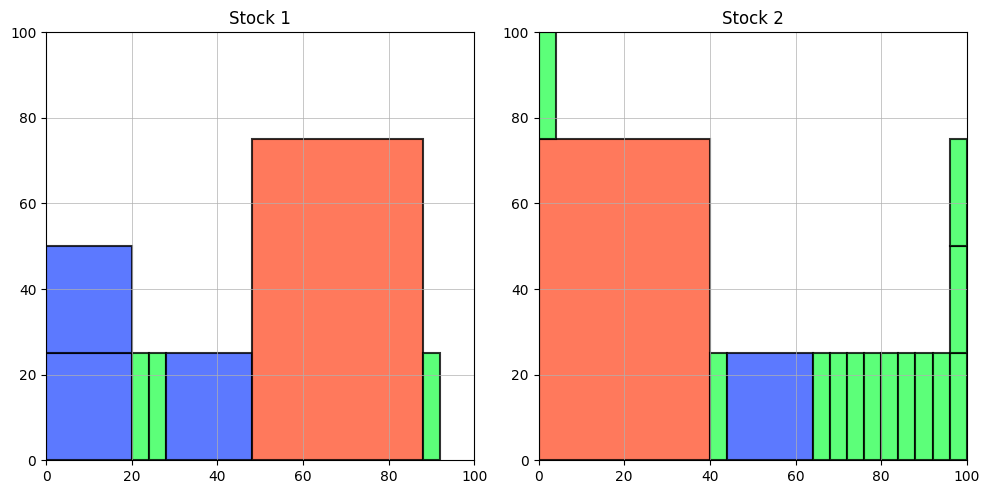

In [13]:
# ============================
# MAIN
# ============================
def main():
    agent = QLearningAgent(alpha=0.1, gamma=0.9, epsilon=0.2)  # Khởi tạo agent QLearning với các tham số alpha, gamma, epsilon
    model_file = "q_table.pkl"  # Đặt tên file dùng để lưu trữ Q-table

    if os.path.exists(model_file):  # Kiểm tra xem file Q-table đã tồn tại hay chưa
        load_q_table(agent, model_file)  # Nếu có, tải Q-table từ file vào agent
        print("Loaded Q-table. Running test episode...")  # In thông báo đã tải Q-table và bắt đầu chạy test episode
        best_env, test_reward = simulate_episode(agent, max_steps=50)  # Chạy một episode thử nghiệm với agent và nhận môi trường cùng tổng reward
        rewards_history = [test_reward]  # Gán rewards_history với danh sách chứa reward của episode thử nghiệm
    else:
        print("No saved Q-table found. Training agent...")  # Nếu không có file Q-table, in thông báo bắt đầu huấn luyện agent từ đầu
        best_env, rewards_history = train_q_learning(agent=agent, num_episodes=500, max_steps=50)  # Huấn luyện agent qua nhiều episode, nhận môi trường tốt nhất và lịch sử rewards
        save_q_table(agent, model_file)  # Lưu Q-table của agent vào file

    plot_training_rewards(rewards_history)  # Vẽ biểu đồ lịch sử rewards theo các episode

    if best_env is not None:  # Nếu tồn tại môi trường tốt nhất (best_env)
        total_area, used_area, waste_area = compute_areas(best_env)  # Tính tổng diện tích của các stock, diện tích đã sử dụng và diện tích lãng phí
        print(f"\nTotal Area = {total_area}")  # In ra tổng diện tích của tất cả các stock
        print(f"Used Area  = {used_area}")     # In ra diện tích đã được sử dụng (sản phẩm đã đặt)
        print(f"Waste Area = {waste_area}")     # In ra diện tích lãng phí (diện tích không sử dụng)
        print_best_solution_summary(best_env)   # In bảng tóm tắt các placement (vị trí đặt sản phẩm) của giải pháp tốt nhất
        visualize_best_solution(best_env)         # Trực quan hóa kết quả của giải pháp tốt nhất bằng biểu đồ

if __name__ == "__main__":  # Kiểm tra nếu file này được chạy trực tiếp (không phải được import từ file khác)
    main()  # Gọi hàm main() để chạy chương trình
